# Problem 18: Data Jobs

_Version 1.3_

Changelog:
- v1.3: Additional clarifications on Exercise 2. [_Dec 4, 2019_]
- v1.2: Revised explanation of how exercises depend upon one another. [_Dec 4, 2019_]
- v1.1: Added clarifying instructions, reorganized some exercises, and tweaked the test code output. [_Dec 3, 2019_]
- v1.0: Initial release candidate.

In this problem, you'll scrape some web data on jobs related to data processing. It should be a straightforward data cleaning task, but ending with some interesting statistics about data-oriented careers that you may find interesting. The problem assesses your general Python and pandas skills.

**Exercises.** There are a total of five (5) exercises, numbered 0-4, worth two (2) points each. Here is how they depend on one another.

- Everything depends on Exercise 0. You have to get that right to make forward-progress.
- Exercises 1 and 2 are independent of one another.
- Exercise 3 depends on both Exercise 1 and 2.
- Exercise 4 depends on both Exercise 1 and 2, but is independent of Exercise 3.

## Setup

Run the following code cell, which will import some modules you may need, as well as some required code for testing and data visualization.

In [1]:
import sys ; sys.path.insert(0, './resource/asnlib/public')
from cse6040utils import tibbles_left_matches_right, tibbles_are_equivalent, make_hash, pandas_df_to_markdown_table

import pandas

%matplotlib inline
from matplotlib.pyplot import figure
from seaborn import lineplot, barplot, color_palette, set_palette

## The dataset

The data for this problem comes from the [H1B Visa Salary Database](https://h1bdata.info/index.php). When US-based companies want to hire highly skilled foreign professionals, they can petition the US government for a special type of visa for such workers to come or stay in the country. The data on which companies have submitted petitions, what base salaries they are proposing to pay such workers, and where the workers will work is publicly available. The H1B Visa Salary Database has aggregated this information from 2013-2019. While it applies to foreign workers only, we can still try to use it to get an idea of what kinds of jobs are available across various job categories and identify some possible trends.

We have downloaded some of this data for the top five cities with the most H1B visa filings. They are New York, San Francisco, Houston, Chicago, and Atlanta. The data for each city is stored in its own file, which is the raw HTML file containing search results when you query the database for a particular city. Here is a screenshot of the query for Atlanta, including all job titles containing the exact substring `'DATA'`, and covering all years (2013-2019).

<img src="resource/asnlib/publicdata/example-h1b-db-results--atl-data-allyears.png" alt="Example: H1B Visa Salary Database Results for 'ATLANTA'" style="width: 800px;"/>

Of course, the HTML output is not directly useful for analysis purposes, so let's start by extracting it and putting into a more usable form, namely, a pandas-based tibble. Then we can analyze it.

## Data extraction

Although the raw data lives in HTML files, for this problem, you don't need to know anything about HTML to work with the data. However, you **do** need to be able to read some Python code, and use that to help you extract the data you'll need.

In particular, we have provided you with some code that uses the Beautiful Soup module to grab all the rows from the table you see in the screenshot above. Even though learning that module was optional (Notebook 6, Part 1), at this point you should know enough Python that you can read some simple code that uses it and figure out how to adapt that code for your needs.

By way of background, here are a few things to know about the data and the next code cell.

- The data for a particular city is stored in a file whose name includes the three-letter code for the city. For example, Atlanta uses the code `atl`; the function, `dataset_path('atl.html')` will return the full file path for the HTML file.
- The function `extract_table_rows()` can read one of these files, and then uses the Beautiful Soup module to extract the table data. You give the function the base filename as a string, like `'atl.html'`, and it returns a special object consisting of that data.

Try running this code to see these two functions in action.

In [2]:
def dataset_path(base_filename):
    return f"./resource/asnlib/publicdata/{base_filename}"

def extract_table_rows(city_html):
    from bs4 import BeautifulSoup
    with open(dataset_path(city_html)) as fp:
        html = BeautifulSoup(fp.read(), 'lxml')
    return html.find_all('tr')

# Pick a city: Atlanta
city, city_name = 'atl', "Atlanta"

# Use `extract_table_rows` to get the table data
rows = extract_table_rows(f"{city}.html")
print(f"The table for {city_name} (`{city}.html`) has {len(rows)} rows, including the header.")
print(f"The returned object, `rows`, has type `{type(rows)}`.")


The table for Atlanta (`atl.html`) has 1582 rows, including the header.
The returned object, `rows`, has type `<class 'bs4.element.ResultSet'>`.


The object that `extract_table_rows()` returns is still a special type of Beautiful Soup object. It is "list-like." In particular, we can reference each row by an integer index and we can loop over the rows.

These rows include the header row you see in the example above. That's the topmost row with the values, `'EMPLOYER'`, `'JOB TITLE'`, `'BASE SALARY'`, and so on. It is the object `rows[0]`. The first data row is `rows[1]`, and in the preceding screenshot is the row whose employer is `'PROTIVITI INC'`.

Given one of the rows, how do you extract the values in that row? The following function, `inspect_html_table_row()`, shows you how. Since you are proficient in Python now, you should be able to study it, observe what happens when calling it on the header row (`rows[0]`), and have a good idea of how to pull out the column values in a given row.

In [3]:
def inspect_html_table_row(row, frontmatter=None):
    if frontmatter is not None:
        print(frontmatter)
    cols = list(row)
    for col_num, col in enumerate(cols):
        print("[{}] '{}'".format(col_num, col.text))
        print("  - Type: {}".format(type(col)))
        print("  - Raw HTML: '{}'".format(str(col)))

header = rows[0]
inspect_html_table_row(header, frontmatter="=== HEADER ===\n") # Header row

=== HEADER ===

[0] 'EMPLOYER'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<th>EMPLOYER</th>'
[1] 'JOB TITLE'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<th>JOB TITLE</th>'
[2] 'BASE SALARY'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<th>BASE SALARY</th>'
[3] 'LOCATION'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<th>LOCATION</th>'
[4] 'SUBMIT DATE'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<th data-date-format="mm/dd/yy">SUBMIT DATE</th>'
[5] 'START DATE'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<th data-date-format="mm/dd/yy">START DATE</th>'
[6] 'CASE STATUS'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<th>CASE STATUS</th>'


Similarly, observe what happens when we apply that same `inspect_html_table_row()` function to the very first row (`rows[1]`) as well as the last one (`rows[-1]`).

In [4]:
first_data_row = rows[1]
inspect_html_table_row(first_data_row, frontmatter="=== FIRST DATA ROW (`rows[1]`) ===\n")

=== FIRST DATA ROW (`rows[1]`) ===

[0] 'PROTIVITI INC'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td><a href="index.php?em=PROTIVITI+INC&amp;job=DATA&amp;city=ATLANTA&amp;year=ALL+YEARS">PROTIVITI INC</a></td>'
[1] 'DATA & ANALYTICS BUSINESS INTELLIGENCE MANAGER'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td><a href="index.php?em=&amp;job=DATA+%26+ANALYTICS+BUSINESS+INTELLIGENCE+MANAGER&amp;city=ATLANTA&amp;year=ALL+YEARS">DATA &amp; ANALYTICS BUSINESS INTELLIGENCE MANAGER</a></td>'
[2] '97,718'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td>97,718</td>'
[3] 'ATLANTA, GA'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td><a href="index.php?em=&amp;job=DATA&amp;city=ATLANTA&amp;year=ALL+YEARS">ATLANTA, GA</a></td>'
[4] '12/04/2015'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td>12/04/2015</td>'
[5] '01/01/2016'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td>01/01/2016</td>'
[6] 'CERTIFIED'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: 

In [5]:
last_data_row = rows[-1]
inspect_html_table_row(last_data_row, frontmatter="=== LAST DATA ROW (`rows[-1]`) ===\n")

=== LAST DATA ROW (`rows[-1]`) ===

[0] 'VENSIT CORP'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td><a href="index.php?em=VENSIT+CORP&amp;job=DATA&amp;city=ATLANTA&amp;year=ALL+YEARS">VENSIT CORP</a></td>'
[1] 'DATAWAREHOUSING SPECIALIST'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td><a href="index.php?em=&amp;job=DATAWAREHOUSING+SPECIALIST&amp;city=ATLANTA&amp;year=ALL+YEARS">DATAWAREHOUSING SPECIALIST</a></td>'
[2] '69,500'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td>69,500</td>'
[3] 'ATLANTA, GA'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td><a href="index.php?em=&amp;job=DATA&amp;city=ATLANTA&amp;year=ALL+YEARS">ATLANTA, GA</a></td>'
[4] '11/17/2016'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td>11/17/2016</td>'
[5] '12/05/2016'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td>12/05/2016</td>'
[6] 'CERTIFIED'
  - Type: <class 'bs4.element.Tag'>
  - Raw HTML: '<td>CERTIFIED</td>'


**Exercise 0** (2 points). Given the HTML results of a H1B jobs query, reconstruct the results as a tibble, stored as a pandas `DataFrame`.

In particular, complete the function, `raw_rows_to_pandas(rows)`, in the code cell below. The input `rows` contains the raw HTML table rows as returned by `extract_table_rows()`. You may assume the following about `rows`:

- It contains only the data rows, **not** the header row.
- The correspondence between columns follows the example from above. That is, the first column (column 0) has `EMPLOYER` values, the second (column 1) has `JOB TITLE` values, the third (column 2) has `BASE SALARY` values, and so on.

The function should return a pandas `DataFrame` object with the following columns:

- `EMPLOYER`: The value of the `EMPLOYER` field from the HTML table, as a string.
- `JOB TITLE`: The value of the `JOB TITLE` field, as a string.
- `LOCATION`: The value of the `LOCATION` field, as a string.
- `BASE SALARY`: The value of the `BASE SALARY` field, as an integer.
- `YEAR`: The 4-digit year extracted from the `SUBMIT DATE` field, converted to an integer.

Your result should **omit** any row where the `CASE STATUS` field does **not** equal the string, `'CERTIFIED'`.

_Example._ For the first and last data rows shown above, the corresponding rows of the pandas `DataFrame` would look like the following:

| EMPLOYER      | JOB TITLE                                      | LOCATION    | BASE SALARY | YEAR |
|---------------|------------------------------------------------|-------------|-------------|------|
| PROTIVITI INC | DATA & ANALYTICS BUSINESS INTELLIGENCE MANAGER | ATLANTA, GA | 97718       | 2015 |
| ...           | ...                                            | ...         | ...         | ...  |
| VENSIT CORP   | DATAWAREHOUSING SPECIALIST                     | ATLANTA, GA | 69500       | 2016 |

Both of these rows have `CASE STATUS` equal to `'CERTIFIED'`, so they are included in the output tibble. (However, the column `CASE STATUS` should **not** be part of the output.)

> _Note 0:_ The ordering of rows and columns does not matter for this problem. The index should be a default index; the simplest way to ensure that is to call `.reset_index()` before returning the final `DataFrame` object.
>
> _Note 1:_ If you are unclear on how to extract the values, refer back to `inspect_html_table_row()` for a hint.
>
> _Note 2:_ Observe that the raw base salaries are strings with pesky embedded commas. You'll need to deal with those.

In [6]:
def raw_rows_to_pandas(rows):
    
    import pandas as pd
    
    df_rows = []
    
    for row in rows:
        cols = list(row)
        if cols[6].text == 'CERTIFIED':
            df_rows.append([cols[0].text,cols[1].text, cols[3].text,\
            int(cols[2].text.replace(',','')), int(cols[4].text[-4:])])
      
    return pd.DataFrame(df_rows, columns = ['EMPLOYER', 'JOB TITLE', 'LOCATION', 'BASE SALARY', 'YEAR'])
                           
# Demo:
atl = raw_rows_to_pandas(rows[1:])
print("Found", len(atl), "rows")
atl.sample(5)

Found 1494 rows


,EMPLOYER,JOB TITLE,LOCATION,BASE SALARY,YEAR
518,HOME DEPOT PRODUCT AUTHORITY LLC,DATA ANALYST SUPPLY CHAIN,"ATLANTA, GA",67500,2018
1371,ANTHEM INC,DATABASE ADMINISTRATOR SENIOR,"ATLANTA, GA",104104,2017
324,HOME DEPOT PRODUCT AUTHORITY LLC,DATA ANALYST - SUPPLY CHAIN,"ATLANTA, GA",61200,2017
932,TATA CONSULTANCY SERVICES LIMITED,DATA WAREHOUSE SPECIALIST,"ATLANTA, GA",72218,2018
144,CAPGEMINI AMERICA INC,DATA ANALYST,"ATLANTA, GA",74200,2016


In [7]:
# Test cell: `exercise0__raw_rows_to_pandas`

# The following may indicate the presence of hidden tests in this cell,
# but in fact, there are none.
###
### AUTOGRADER TEST - DO NOT REMOVE
###

def check0():
    from pandas import read_csv
    from numpy import issubdtype, integer
    rows = extract_table_rows('atl.html')
    df = raw_rows_to_pandas(rows[1:])
    df_soln_hashed = read_csv(dataset_path(f"ex0_atl_soln.csv"))
    assert set(df.columns) == {'EMPLOYER', 'JOB TITLE', 'LOCATION', 'BASE SALARY', 'YEAR'}, \
           f"Your output has these columns, which don't match our requirements:\n{set(df.columns)}."
    for col in ['EMPLOYER', 'JOB TITLE', 'LOCATION']:
        assert df[col].apply(lambda x: isinstance(x, str)).all(), \
               f"Column '{col}' may have one or more values that are not strings."
    for col in ['BASE SALARY', 'YEAR']:
        assert df[col].apply(lambda x: isinstance(x, int)).all(), \
               f"Column '{col}' may have one or more values that are not of type `int`."
    assert len(df) == len(df_soln_hashed), \
           f"Expected {len(df_soln_hashed)} rows in the table, but you have {len(df)}."
    assert tibbles_left_matches_right(df, df_soln_hashed, hash_A=True, verbose=True), \
           "Your solution does not match what we expected to see. Please try again!"
    
check0()

print("\n(Passed.)")


(Passed.)


To start, here is a list of all the unique job titles in the Atlanta data:

In [8]:
atl_job_titles = atl['JOB TITLE'].unique()
print(f"There are {len(atl_job_titles)} unique job titles in the Atlanta dataset.")
print(f"They are:\n{atl_job_titles}")

There are 198 unique job titles in the Atlanta dataset.
They are:
['DATA & ANALYTICS BUSINESS INTELLIGENCE MANAGER'
 'DATA & ANALYTICS ENGINEER'
 'DATA & ANALYTICS ETL DEVELOPER SENIOR CONSULTANT'
 'DATA & DECISION SCIENCE MANAGER' 'DATA & INSIGHT ANALYST'
 'DATA ANALYSIS & SIMULATION PROF'
 'DATA ANALYSIS & SIMULATION PROFESSIONAL' 'DATA ANALYST'
 'DATA ANALYST  DEVELOPER' 'DATA ANALYST  IT SPECIALIST'
 'DATA ANALYST  TESTER'
 'DATA ANALYST - INFORMATION MANAGEMENT AND GOVERNANCE'
 'DATA ANALYST - ITEM MANAGEMENT' 'DATA ANALYST - SUPPLY CHAIN'
 'DATA ANALYST 1' 'DATA ANALYST 2' 'DATA ANALYST 3' 'DATA ANALYST 4'
 'DATA ANALYST ENGINEER' 'DATA ANALYST ENVIRONMENTAL' 'DATA ANALYST I'
 'DATA ANALYST II' 'DATA ANALYST III' 'DATA ANALYST JR. EPIDEMIOLOGIST'
 'DATA ANALYST LEAD - INFORMATICA ADMINISTRATOR' 'DATA ANALYST SC'
 'DATA ANALYST SR.' 'DATA ANALYST SUPPLY CHAIN'
 'DATA ANALYST, DATA AND ANALYTICS' 'DATA ANALYTIC SCIENTIST'
 'DATA ANALYTICS' 'DATA ANALYTICS & OPERATIONS RESEARCH ANAL

## Exercises: Data filtering

For your first task, let's take a peek at the data and consider some different types of filtering we might want to do.

The next code cell defines a function, `subset_series_str(s, pattern)`, that we'll find handy. Given a pandas `Series` object, `s`, that contains strings, this function returns the subset of `s` where the regular expression pattern `pattern` matches. Read the code inside this function and run the cell.

In [9]:
def subset_series_str(s, pattern):
    """Given a Series object, `s`, returns the subset containing the regular expression `pattern`."""
    from pandas import Series
    if not isinstance(s, Series):
        s = Series(s) # Attempt to convert...
    return s[s.str.contains(pattern)]

As a quick demo, let's use this function to find all job titles containing the word `'DATA'` followed by the word `'SCIENTIST'`, possibly with arbitrary text in between the two words.

In [10]:
jobs_with_data_followed_by_scientist = subset_series_str(atl_job_titles, r'.*DATA.*SCIENTIST.*')
jobs_with_data_followed_by_scientist

29                               DATA ANALYTIC SCIENTIST
40                              DATA ANALYTICS SCIENTIST
106                                       DATA SCIENTIST
107                      DATA SCIENTIST  ENGINEER SENIOR
108                              DATA SCIENTIST - CAREER
109                       DATA SCIENTIST - FLIGHT SAFETY
110                        DATA SCIENTIST - INTERMEDIATE
111                              DATA SCIENTIST - ONLINE
112                  DATA SCIENTIST - SPACE OPTIMIZATION
113                                     DATA SCIENTIST 1
114                                     DATA SCIENTIST I
115                                    DATA SCIENTIST II
116                               DATA SCIENTIST PRICING
117                   DATA SCIENTIST, ADVANCED ANALYTICS
118    DATA SCIENTIST-CONSUMER CLIENT & CHANNEL ANALY...
119                        DATA SCIENTIST-TRANSFORMATION
dtype: object

So one observation we can make about the raw job titles is that there can be many variations and similar-sounding titles. We'll do some aggregation to simplify our analysis of different job categories later, but for now, just note this fact.

**Exercise 1** (2 points). Write a function that will filter a jobs `DataFrame` so that it contains only the subset of rows whose job titles match any of a given list of substrings.

In particular, implement `filter_jobs(df, target_jobs)` as follows:

* Let `df` be a pandas `DataFrame` containing a column named `'JOB TITLE'`, which holds job titles.
* Let `target_jobs` be a **list** of substrings to match in the `'JOB TITLE'` column. For instance, suppose `target_jobs=['DATA ANALYST', 'DATABASE ADMINISTRATOR', 'DATA SCIENTIST', 'DATA ENGINEER']`. Then your function should return rows of `df` where the job title contains any of those substrings.
* Your function should look for **exact substrings**. For example, if `'DATA SCIENTIST'` is one of the substrings, then `'DATA SCIENTIST II'` and `'DATA SCIENTIST, ADVANCED ANALYTICS'` should match, but `'DATA ANALYTIC SCIENTIST'` should not.

In [11]:
def filter_jobs(df, target_jobs):
    from pandas import DataFrame
    assert isinstance(df, DataFrame), f"`df` has type `{type(df)}` rather than `DataFrame`."
    assert 'JOB TITLE' in df.columns, f"`df` does not have a `'JOB TITLE'` column."
    assert all([isinstance(j, str) for j in target_jobs]), f"All entries of `target_jobs` should be strings."
    
    return df.loc[df['JOB TITLE'].apply(lambda x: any( job in x for job in target_jobs))]


#keep_job = df['JOB TITLE'].str.contains('|'.join(target_jobs))
#return df[keep_job]
    
# Demo: The following should yield only the four target job titles.
target_job_list = ['DATA ANALYST', 'DATABASE ADMINISTRATOR', 'DATA SCIENTIST', 'DATA ENGINEER']
atl_target_jobs = filter_jobs(atl, target_job_list)
print(atl_target_jobs['JOB TITLE'].unique())

['DATA ANALYST' 'DATA ANALYST  DEVELOPER' 'DATA ANALYST  IT SPECIALIST'
 'DATA ANALYST  TESTER'
 'DATA ANALYST - INFORMATION MANAGEMENT AND GOVERNANCE'
 'DATA ANALYST - ITEM MANAGEMENT' 'DATA ANALYST - SUPPLY CHAIN'
 'DATA ANALYST 1' 'DATA ANALYST 2' 'DATA ANALYST 3' 'DATA ANALYST 4'
 'DATA ANALYST ENGINEER' 'DATA ANALYST ENVIRONMENTAL' 'DATA ANALYST I'
 'DATA ANALYST II' 'DATA ANALYST III' 'DATA ANALYST JR. EPIDEMIOLOGIST'
 'DATA ANALYST LEAD - INFORMATICA ADMINISTRATOR' 'DATA ANALYST SC'
 'DATA ANALYST SR.' 'DATA ANALYST SUPPLY CHAIN'
 'DATA ANALYST, DATA AND ANALYTICS' 'DATA ENGINEER'
 'DATA ENGINEER  HADOOP DEVELOPER' 'DATA ENGINEER ANALYST SENIOR'
 'DATA ENGINEER II' 'DATA ENGINEER III'
 'DATA ENGINEERING ASSOCIATE MANAGER' 'DATA ENGINEERING SENIOR ANALYST'
 'DATA SCIENTIST' 'DATA SCIENTIST  ENGINEER SENIOR'
 'DATA SCIENTIST - CAREER' 'DATA SCIENTIST - FLIGHT SAFETY'
 'DATA SCIENTIST - INTERMEDIATE' 'DATA SCIENTIST - ONLINE'
 'DATA SCIENTIST - SPACE OPTIMIZATION' 'DATA SCIENTIST 1

In [12]:
# Test cell: `exercise1__filter_data_jobs`

# The following may indicate the presence of hidden tests in this cell,
# but in fact, there are none.
###
### AUTOGRADER TEST - DO NOT REMOVE
###

def check1():
    from pandas import read_csv
    rows = extract_table_rows('atl.html')
    df = raw_rows_to_pandas(rows[1:])
    target_job_list = ['DATA ANALYST', 'DATABASE ADMINISTRATOR', 'DATA SCIENTIST', 'DATA ENGINEER']
    df_reduced = filter_jobs(df, target_job_list)
    df_soln_hashed = read_csv(dataset_path(f"ex1_atl_soln.csv"))
    assert tibbles_left_matches_right(df_reduced, df_soln_hashed, hash_A=True, verbose=True), \
           "Your solution does not match what we expected to see. Please try again!"
    
check1()

print("\n(Passed.)")


(Passed.)


**Normalizing job titles.** To simplify our analysis, let's give job titles that "look the same" a simpler name. We'll refer to this process as "normalizing" distinct but similar job titles into a simple title.

**Exercise 2** (2 points). Suppose you are given a pandas `Series` object `s` and a string, `target`. Implement the function `normalize_series(s, target)` so that it returns a copy of `s` where any element containing the exact substring `target` is replaced with just `target`. **The returned `Series` object must have the same index as `s`.**

For example, suppose the input `Series`, `s`, is

```python
3                DATA ANALYTIC SCIENTIST
1                    BEST DATA SCIENTIST
4                         DATA SCIENTIST
0    DATA SCIENTIST - SPACE OPTIMIZATION
2                         SCIENTIST DATA
dtype: object
```

Then, the expression

```python
print(normalize_series(s, 'DATA SCIENTIST'))
```

would display the `Series`

```python
3                DATA ANALYTIC SCIENTIST
1                         DATA SCIENTIST
4                         DATA SCIENTIST
0                         DATA SCIENTIST
2                         SCIENTIST DATA
dtype: object
```

In other words, only the two entries containing the exact substring, `'DATA SCIENTIST'`, are changed to `'DATA SCIENTIST'`; all other entries remain unchanged. Also, note that the index values of the two `Series` are identical.

In [13]:
def normalize_series(s, target):
    from pandas import Series
    assert isinstance(s, Series), f"Object `s` has type `{type(s)}`, not `Series`."
    assert isinstance(target, str), f"`target` is a `{type(target)}`, not a string."
    
    return s.apply(lambda x: target if target in x else x)

#return s.str.replace('.*' + target + '.*', target)
    
# Demo: Does your output look as expected?
s_in = pandas.Series(['DATA ANALYTIC SCIENTIST',
                      'BEST DATA SCIENTIST',
                      'DATA SCIENTIST',
                      'DATA SCIENTIST - SPACE OPTIMIZATION',
                      'SCIENTIST DATA'])
s_in.index = [3, 1, 4, 0, 2]
print("=== Before ===\n")
display(s_in)
print("\n=== After ===\n")
normalize_series(s_in, 'DATA SCIENTIST')

=== Before ===



3                DATA ANALYTIC SCIENTIST
1                    BEST DATA SCIENTIST
4                         DATA SCIENTIST
0    DATA SCIENTIST - SPACE OPTIMIZATION
2                         SCIENTIST DATA
dtype: object


=== After ===



3    DATA ANALYTIC SCIENTIST
1             DATA SCIENTIST
4             DATA SCIENTIST
0             DATA SCIENTIST
2             SCIENTIST DATA
dtype: object

In [14]:
# Test cell: `exercise2__normalize_series`

def gen_text2(word1, word2):
    from random import random, randrange, choices
    def random_word(max_len):
        return ''.join([chr(ord('A')+randrange(0, 26)) for _ in range(randrange(0, max_len))])
    u, match = random(), False
    if u < 0.5:
        text = f"{random_word(5)} {word1} {word2} {random_word(5)}"
        match = True
    elif u < 0.66:
        middle = random_word(5)
        if len(middle) > 0:
            text = f"{random_word(5)} {word1} {middle} {word2} {random_word(5)}"
        else:
            text = f"{random_word(5)} {word1} {word2} {random_word(5)}"
            match = True
    elif u < 0.75:
        text = f"{random_word(5)} {word2} {word1} {random_word(5)}"
    else:
        text = f"{random_word(5)} {word2} {random_word(5)} {word1} {random_word(5)}"
    return text, match

def gen_series2(word1, word2, m=10):
    from pandas import Series
    from random import randrange, shuffle
    texts_before = []
    texts_after = []
    for _ in range(randrange(1, m)):
        text, match = gen_text2(word1, word2)
        texts_before.append(text)
        texts_after.append(text if not match else f"{word1} {word2}")
    index_values = list(range(len(texts_before)))
    shuffle(index_values)
    s_before = Series(texts_before, index=index_values)
    s_after = Series(texts_after, index=index_values)
    return s_before, s_after

def check2():
    from random import choice
    from pandas import Series
    word1 = 'DATA'
    word2 = choice(['SCIENTIST', 'ENGINEER', 'ANALYTICS'])
    pattern = f"{word1} {word2}"
    s, soln = gen_series2(word1, word2)
    try:
        s_norm = normalize_series(s, pattern)
        assert isinstance(s_norm, type(Series([]))), "You did not return a 'Series' object."
        assert (s_norm.index == soln.index).all(), "Index values do not match."
        assert (s_norm == soln).all(), "An error was detected."
    except:
        print("=== Failing test case ===")
        print("* Input Series:")
        display(s)
        print(f"* Pattern: {pattern}")
        print("* Expected output:")
        display(soln)
        print("* Your output:")
        display(s_norm)
        raise

for _ in range(10):
    check2()
    
print("\n(Passed.)")


(Passed.)


<ipython-input-14-9a7d654a2edf>:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  assert isinstance(s_norm, type(Series([]))), "You did not return a 'Series' object."
<ipython-input-14-9a7d654a2edf>:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  assert isinstance(s_norm, type(Series([]))), "You did not return a 'Series' object."
<ipython-input-14-9a7d654a2edf>:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  assert isinstance(s_norm, type(Series([]))), "You did not return a 'Series' object."
<ipython-input-14-9a7d654a2edf>:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Spe

**Reducing job titles.** In our subsequent analysis, we will use normalized job titles for four cases: `'DATA SCIENTIST'`, `'DATA ANALYST'`, `'DATA ENGINEER'`, and `'DATABASE ADMINISTRATOR'`. These titles are stored in the `TARGET_JOBS` variable defined in the next code cell.

That cell also defines a new function, `reduce_jobs(df)`. It takes a data frame `df` having a `'JOB TITLE'` column, and replaces that column with normalized versions of the jobs in `TARGET_JOBS`.

In [15]:
TARGET_JOBS = ['DATA SCIENTIST', 'DATA ANALYST', 'DATA ENGINEER', 'DATABASE ADMINISTRATOR']

def reduce_jobs(df, target_jobs=TARGET_JOBS):
    df_reduced = df.copy()
    for title in target_jobs:
        df_reduced['JOB TITLE'] = normalize_series(df_reduced['JOB TITLE'], title)
    return df_reduced

atl_reduced = reduce_jobs(atl)
atl_reduced.sample(5)

,EMPLOYER,JOB TITLE,LOCATION,BASE SALARY,YEAR
324,HOME DEPOT PRODUCT AUTHORITY LLC,DATA ANALYST,"ATLANTA, GA",61200,2017
1028,DW PRACTICE LLC,DATABASE ADMINISTRATOR,"ATLANTA, GA",60000,2015
1436,GEMINI CONSULTING & SERVICES LLC,DATABASE ARCHITECT,"ATLANTA, GA",92000,2018
659,IBM CORPORATION,DATA INTEGRATION LEAD,"ATLANTA, GA",72218,2018
158,CAPGEMINI AMERICA INC,DATA ANALYST,"ATLANTA, GA",74200,2016


To get a feel for the data, let's tally the number of jobs associated with each (normalized) job title and look at the top ten. If everything above went well, you should see that in the Atlanta market, the most H1B jobs are represented by data analysts, database administrators, data scientists, and data engineers.

In [16]:
atl_reduced_job_counts = atl_reduced['JOB TITLE'].value_counts()
atl_reduced_job_counts.head(10)

DATA ANALYST                 530
DATABASE ADMINISTRATOR       424
DATA SCIENTIST               136
DATA ENGINEER                 42
DATA SPECIALIST               30
DATA WAREHOUSE SPECIALIST     29
DATABASE ANALYST              24
DATA ARCHITECT                22
DATABASE DEVELOPER            18
DATABASE ARCHITECT            14
Name: JOB TITLE, dtype: int64

## Exercises: Data analysis!

For the remainder of this notebook, let's do a couple quick and dirty analyses of this data. You won't do anything too complicated; some simple summary and descriptive statistics will be enough to assess your pandas-fu skills.

Assuming the above went well, let's reduce the job titles to just the four main targets (`TARGET_JOBS`) and make a quick plot of how their base salaries have changed over time.

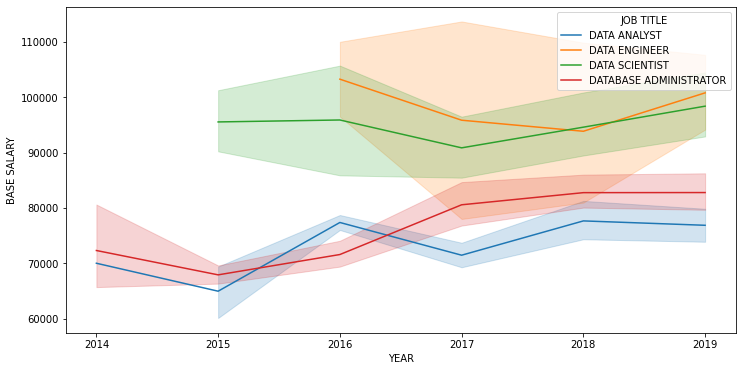

In [17]:
atl_reduced2 = atl_reduced.loc[atl_reduced['JOB TITLE'].isin(TARGET_JOBS)]

fig = figure(figsize=(12, 6))
lineplot(x='YEAR', y='BASE SALARY', hue='JOB TITLE', data=atl_reduced2)
set_palette(color_palette('colorblind'))

**Aside:** Observe that in the Atlanta market, by 2019, there is a distinct gap between the salaries of data scientists and engineers from database administrators and data analysts. However, salaries seem mostly flat, with the possible exception of an arguably slight increase in base salaries for database adminstrators. Assuming this holds for other markets, we will aggregate over the year field in the exercises that follow.

### Median salaries

Let's start by looking at median salaries in the Atlanta market.

**Exercise 3** (2 points). Suppose we wish to know the median base salaries for each unique job title. Complete the function `get_median_salaries_by_title(df)`, so that it does so.

In particular, your function should do the following:

- You should return a tibble as a pandas `DataFrame` containing two columns: `'JOB TITLE'` and `'BASE SALARY'`. To get a proper tibble, reset the index before returning the final result.
- For each unique job title, the base salary value should be the median for that job title.
- Store the median salaries as **integers**. If calculating the median produces floating-point values, simply convert the column so that it holds integers (thereby truncating the floating-point values).
- Do **not** use `reduce_jobs()`. Whoever uses your function will decide whether or not to do that, and in particular, the test cell runs one test case that does do so and one that does not.
- The order in which rows or columns appear does **not** matter.

In [18]:
def get_median_salaries_by_title(df):
    from pandas import DataFrame
    assert isinstance(df, DataFrame)
    
    df = df.groupby('JOB TITLE')['BASE SALARY'].median().astype('int').reset_index()
    
    return df

#df_return = df[['JOB TITLE', 'BASE SALARY']].groupby('JOB TITLE').median().reset_index()
#df_return['BASE SALARY'] = df_return['BASE SALARY'].astype(int)
#return df_return
    
# Demo. Which title has the highest median salary in the Atlanta market?
get_median_salaries_by_title(atl_reduced2)

,JOB TITLE,BASE SALARY
0,DATA ANALYST,74200
1,DATA ENGINEER,95278
2,DATA SCIENTIST,90106
3,DATABASE ADMINISTRATOR,75000


In [19]:
# Test cell: `exercise3__get_median_salaries_by_title`

# The following may indicate the presence of hidden tests in this cell,
# but in fact, there are none.
###
### AUTOGRADER TEST - DO NOT REMOVE
###

def check3(reduce):
    from pandas import read_csv
    rows = extract_table_rows('atl.html')
    df = raw_rows_to_pandas(rows[1:])
    target_job_list = ['DATA ANALYST', 'DATABASE ADMINISTRATOR', 'DATA SCIENTIST', 'DATA ENGINEER']
    df = filter_jobs(df, target_job_list)
    if reduce:
        df = reduce_jobs(df)
    df_soln = get_median_salaries_by_title(df)
    soln_csv = dataset_path(f"ex3{'b' if reduce else 'a'}_atl_soln.csv")
    print(f"Checking against hashed solution, {soln_csv}.")
    df_soln_hashed = read_csv(soln_csv)
    assert tibbles_left_matches_right(df_soln, df_soln_hashed, hash_A=True, verbose=True), \
           "Your solution does not match what we expected to see. Please try again!"
    
check3(False) # do not reduce jobs first
check3(True)  # reduce jobs first

print("\n(Passed.)")

Checking against hashed solution, ./resource/asnlib/publicdata/ex3a_atl_soln.csv.
Checking against hashed solution, ./resource/asnlib/publicdata/ex3b_atl_soln.csv.

(Passed.)


### Median salaries across all markets

As a final step, let's compare median salaries across the Top 5 markets.

But before doing so, observe one fact about the `'LOCATION'` column: like the job title column, there are typically several variations on how the location is written. For instance, run this cell to see what happens in the casee of Atlanta:

In [20]:
atl['LOCATION'].unique()

array(['ATLANTA, GA', 'ATLANTA,, GA', 'ATLANTA, SANDY SPRINGS, GA'],
      dtype=object)

Therefore, when you pull data together from different locations in Exercise 4, you will do some normalization, as described therein.

**Exercise 4** (2 points). Write some code that constructs a tibble named `df_summary`, stored as a pandas `DataFrame`, that contains data aggregated across all of the Top 5 markets. Recall that these markets are New York, San Francisco, Houston, Chicago, and Atlanta. These data are stored in the files `'nyc.html'`, `'sfo.html'`, `'hou.html'`, `'chi.html'`, and `'atl.html'`.

> Recall that you can use the function, `extract_table_rows()`, to get the raw HTML row data, and `raw_rows_to_pandas()` to convert these into a basic data frame object.

The structure of `df_summary` should be as follows.

- It should have three columns: `'JOB TITLE'`, `'BASE SALARY'`, and `'LOCATION'`.
- The `'LOCATION'` column should be simplified. In particular, overwrite the `'LOCATION'` field using just the following city names in each market: `'NEW YORK'`, `'SAN FRANCISCO'`, `'HOUSTON'`, `'CHICAGO'`, and `'ATLANTA'`.
- The `'JOB TITLE'` field should also be simplified, using the `reduce_jobs()` function.
- Filter the jobs to include only the four target jobs (i.e., see `TARGET_JOBS`).
- In the `'BASE SALARY'` column, store the median value aggregated by (grouped by) location and job title. Store this value as an integer, meaning any floating-point values should simply be truncated.
- To get a proper tibble at the end, consider resetting the index.

In [24]:
CITY_NAMES = {'nyc': 'NEW YORK',
              'sfo': 'SAN FRANCISCO',
              'hou': 'HOUSTON',
              'chi': 'CHICAGO',
              'atl': 'ATLANTA'}

import pandas as pd

df_list = []

for code, name in CITY_NAMES.items():
    df_city = filter_jobs(reduce_jobs(raw_rows_to_pandas(extract_table_rows(f'{code}.html')[1:])), TARGET_JOBS)
    df_city['LOCATION'] = name
    df_list.append(df_city)

df_summary = pd.concat(df_list)

df_summary = df_summary[['JOB TITLE', 'BASE SALARY', 'LOCATION']]

df_summary = df_summary.groupby(['JOB TITLE', 'LOCATION'])['BASE SALARY'].median().astype(int).reset_index()


# Peek at your result:
display(df_summary)

,JOB TITLE,LOCATION,BASE SALARY
0,DATA ANALYST,ATLANTA,74200
1,DATA ANALYST,CHICAGO,74200
2,DATA ANALYST,HOUSTON,74600
3,DATA ANALYST,NEW YORK,71800
4,DATA ANALYST,SAN FRANCISCO,95000
5,DATA ENGINEER,ATLANTA,95278
6,DATA ENGINEER,CHICAGO,90000
7,DATA ENGINEER,HOUSTON,91707
8,DATA ENGINEER,NEW YORK,110000
9,DATA ENGINEER,SAN FRANCISCO,121077


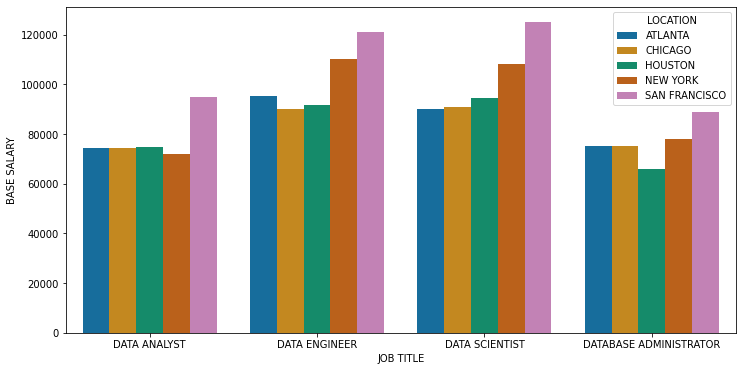

In [25]:
# Quick plot
figure(figsize=(12, 6))
g = barplot(x='JOB TITLE', y='BASE SALARY', hue='LOCATION', data=df_summary)
set_palette(color_palette('colorblind'))

In [26]:
# Test cell: `exercise4__df_summary`

# The following may indicate the presence of hidden tests in this cell,
# but in fact, there are none.
###
### AUTOGRADER TEST - DO NOT REMOVE
###

def check4(df_summary):
    from pandas import read_csv
    soln_csv = dataset_path(f"ex4_soln.csv")
    print(f"Checking against hashed solution, {soln_csv}.")
    df_soln_hashed = read_csv(soln_csv)
    assert tibbles_left_matches_right(df_summary, df_soln_hashed, hash_A=True, verbose=True), \
           "Your solution does not match what we expected to see. Please try again!"
    
check4(df_summary)

print("\n(Passed.)")

Checking against hashed solution, ./resource/asnlib/publicdata/ex4_soln.csv.

(Passed.)


**Fin!** You’ve reached the end of this part. Don’t forget to restart and run all cells again to make sure it’s all working when run in sequence; and make sure your work passes the submission process. If the autograder seems to fail, be sure to inspect the grading report for more information. Good luck!

Of course, the analysis conducted above is just the tip of the iceberg in terms of what you could mine from the H1B data. If you have time after the exam is over, take some time to ask and answer your own questions about it! For instance, which companies are offering the highest base salaries for the type of data analysis job you are after? If you need some inspiration, refer to the following two-part blog post, which was the source of the ideas for this problem: [Part 1](https://towardsdatascience.com/how-much-do-data-scientists-make-cbd7ec2b458) and [Part 2](https://towardsdatascience.com/how-much-do-data-scientists-make-part-2-cb959a0d05f).